Архитектура классического Трансформера состоит из энкодера и декодера. Она используется для задачи машинного перевода — преобразования одной последовательности в другую, длина которых может не совпадать (sequence-to-sequence).

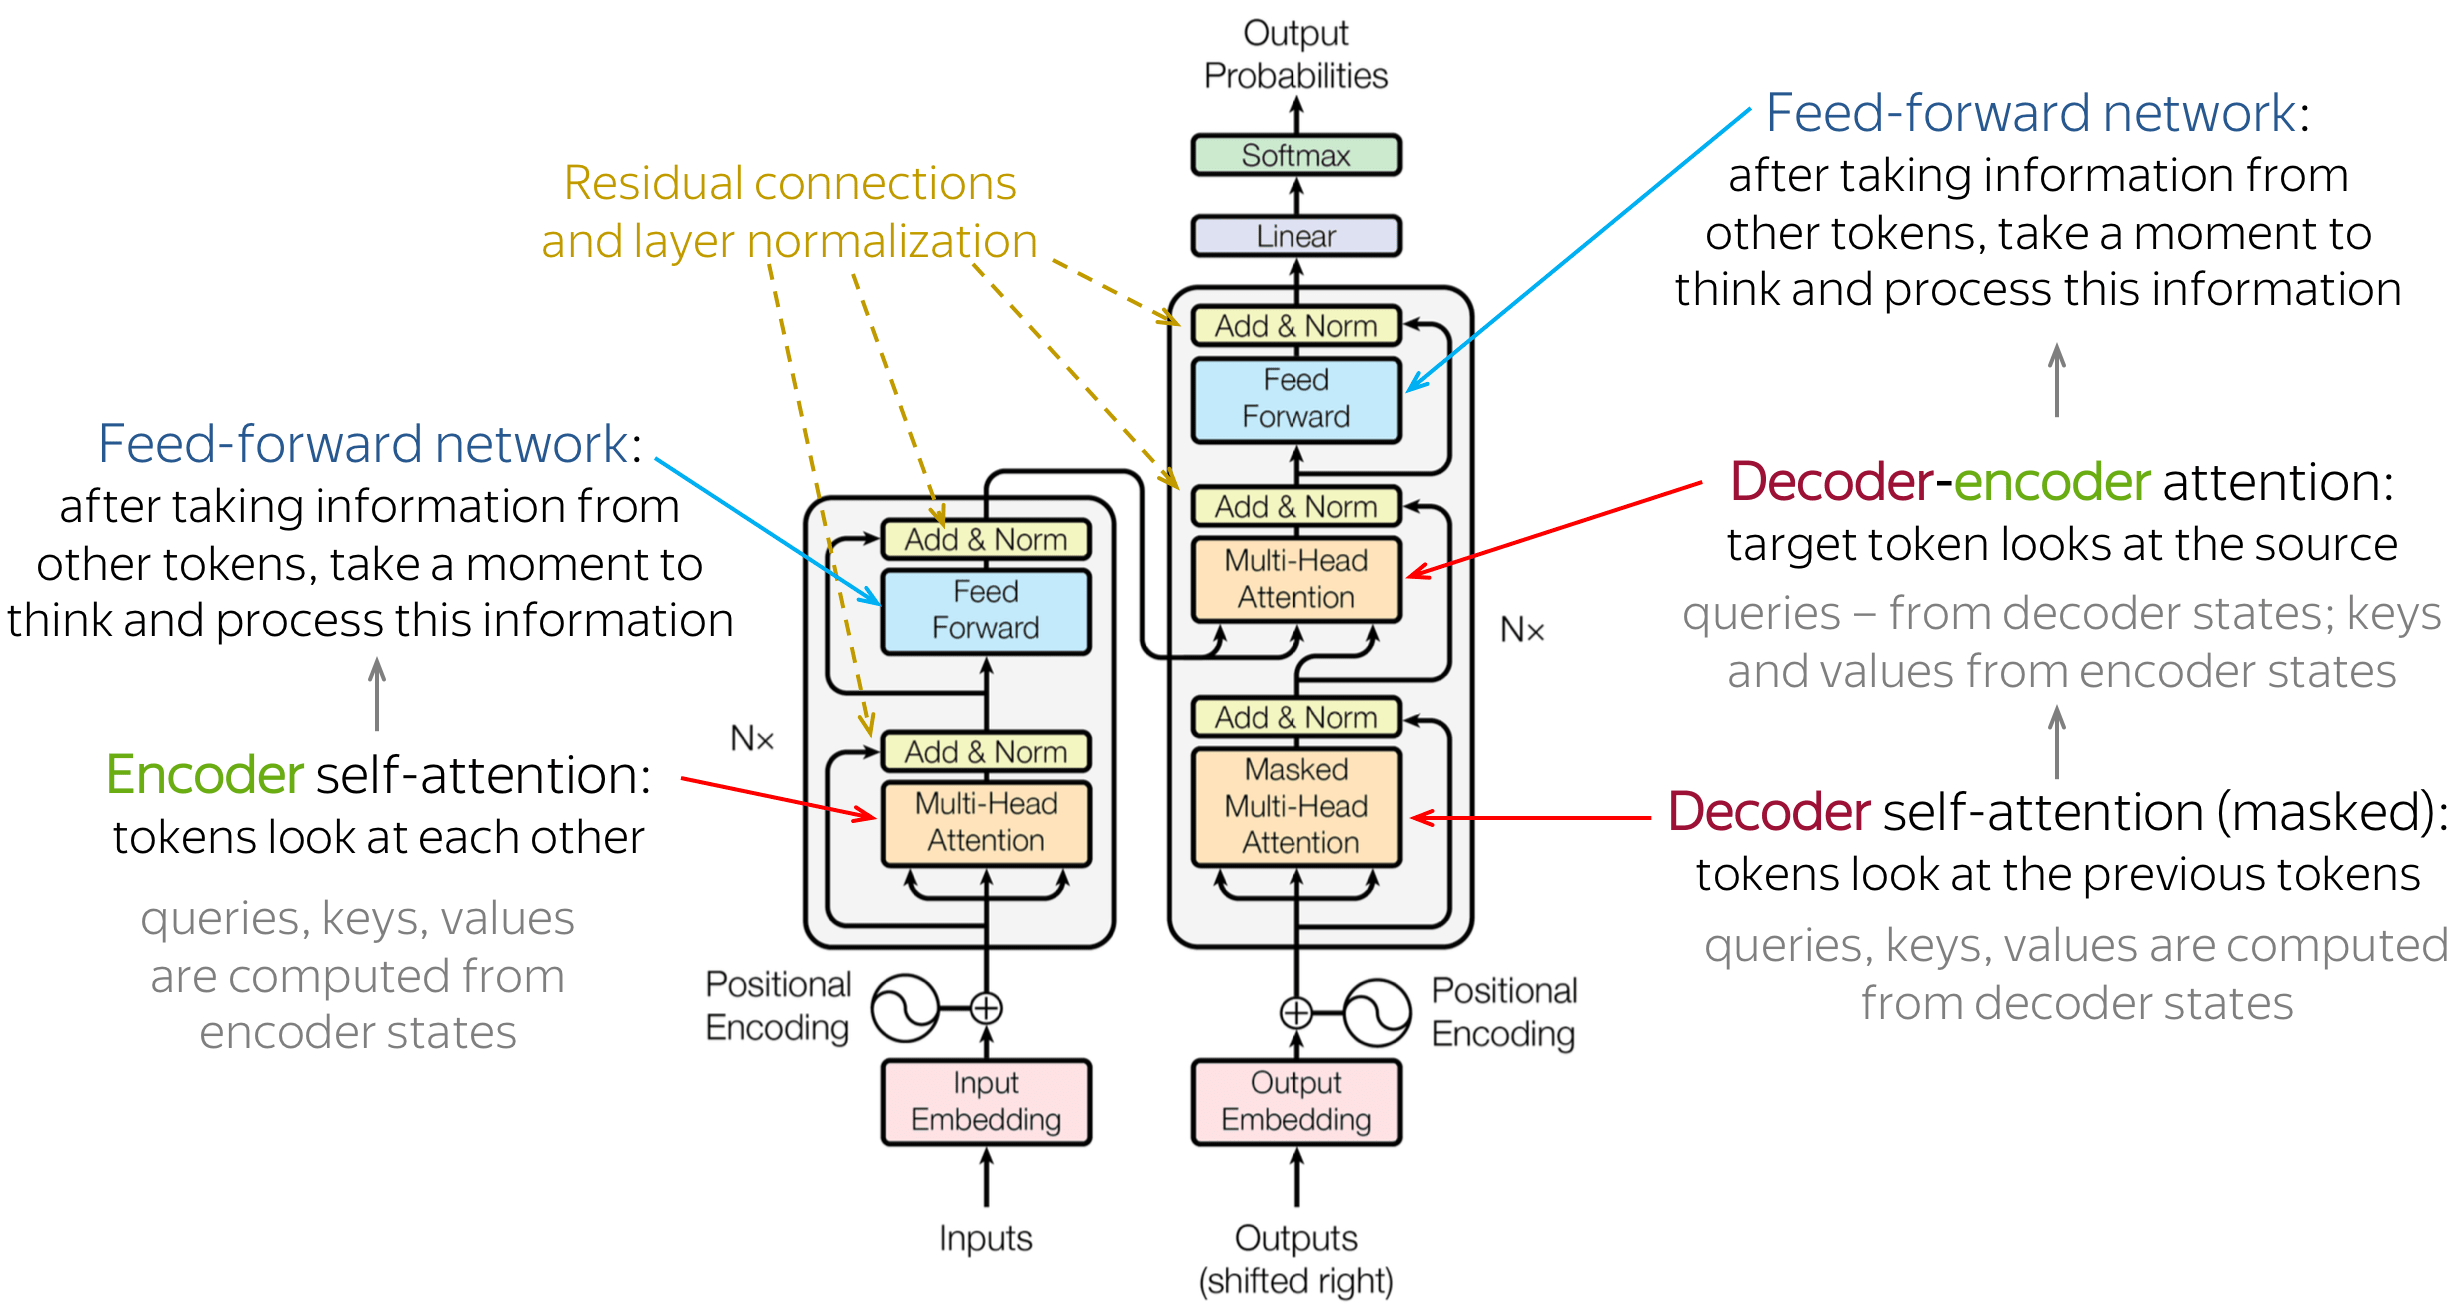

Однако блоки энкодера и декодера можно использовать по отдельности.
- Модели на основе декодера используются для генерации текста и используют маскированное внимание (Generative pre-trained transformers, GPT)
- Модели на основе энкодера используются для других задач: классификации одного или пары предложений, теггирования последовательности, поиска ответа на вопрос (Bidirectional Encoder Representations from Transformers, BERT)

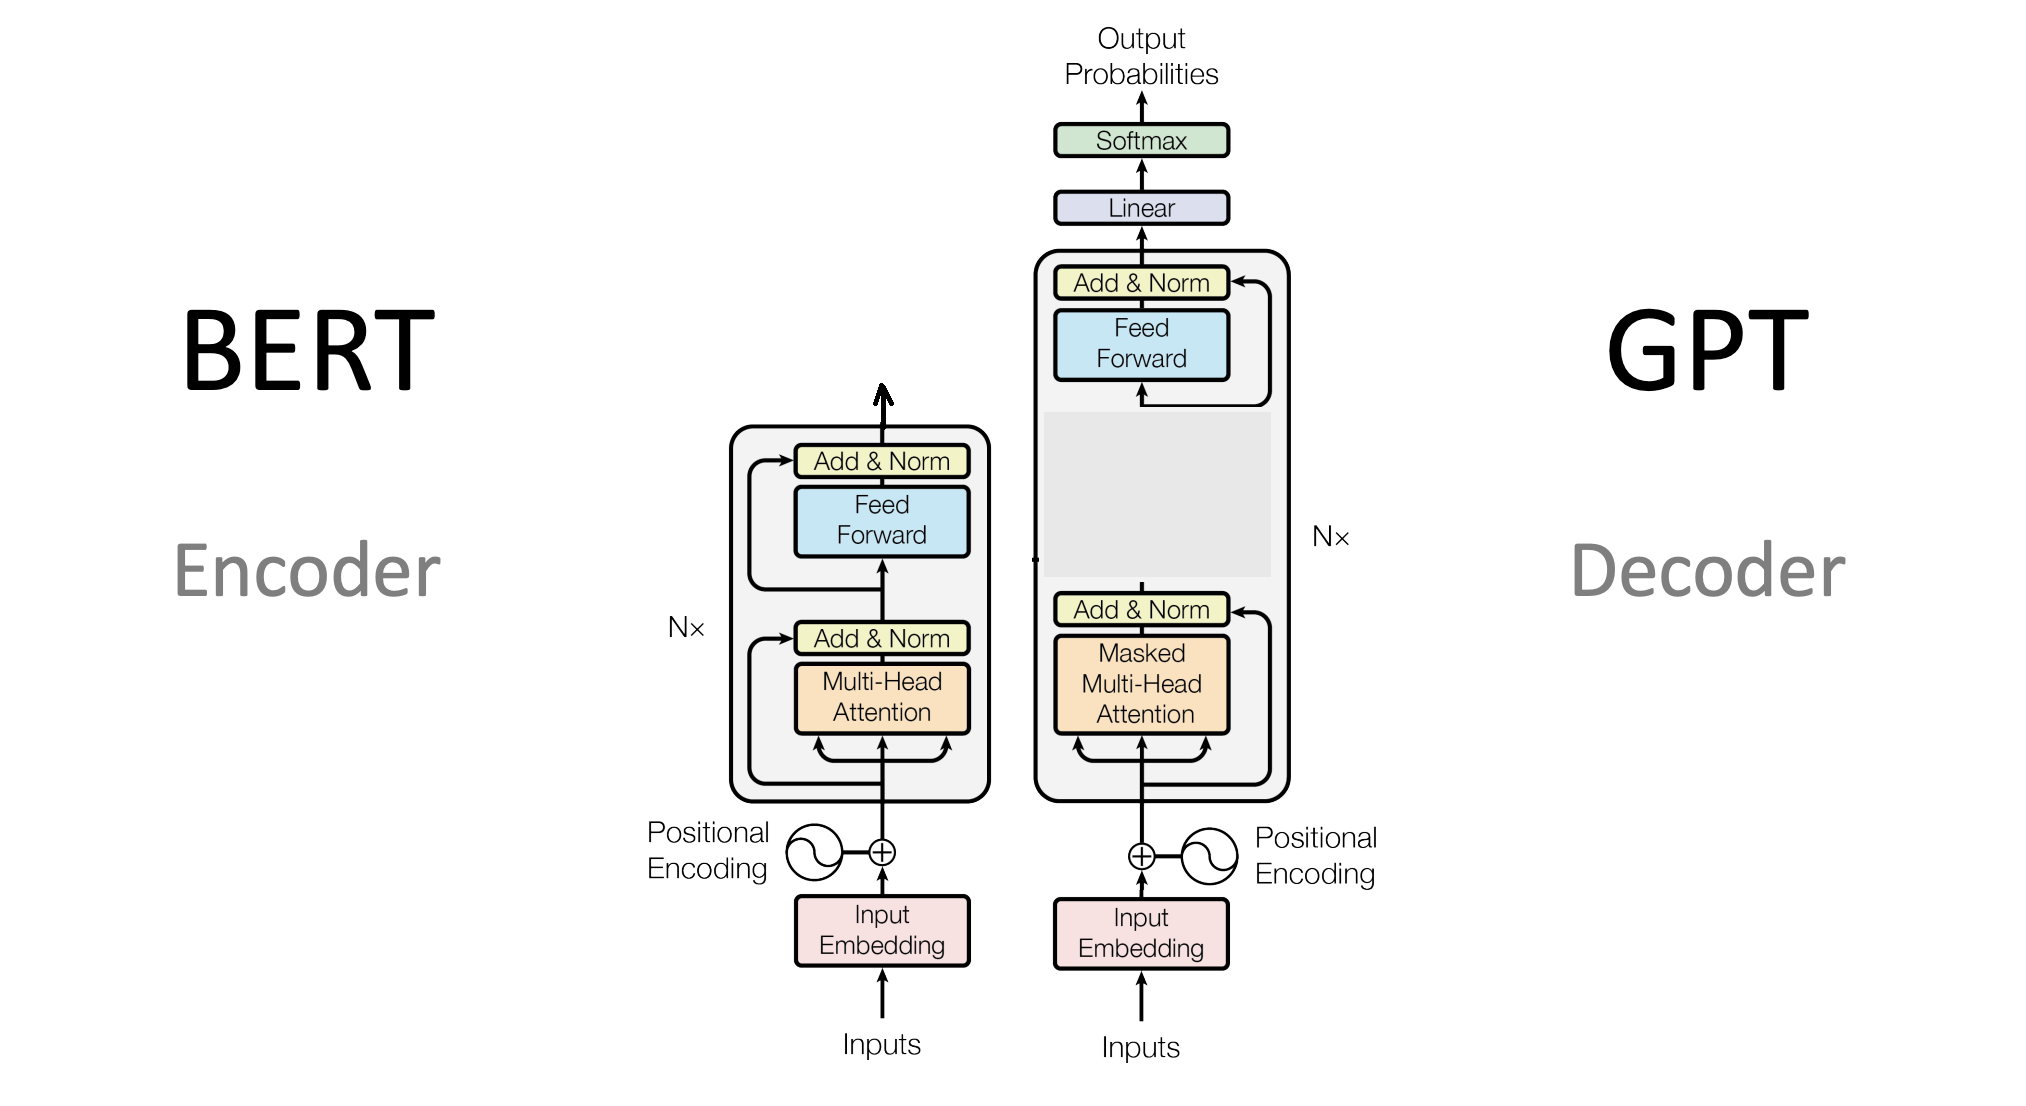

Сегодня мы подробно рассмотрим архитектуру модели BERT и её применение для различных задач. BERT возник как результат исправления недочетов предыдущих моделей, поэтому рассказ про него мы начнем немного издалека.

## Первая модель на улице Сезам — ELMo

Модель ELMo была представлена в статье [Deep contextualized word representations](https://arxiv.org/abs/1802.05365).

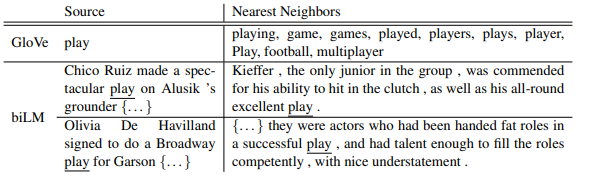

Различным значениям слова *play* соответствуют разные контексты
употребления. Нужно передавать не только значение слова, но и контекстуальную
информацию – **контекстуализированные векторные
представления слов**. Контекстуализированные эмбеддинги присваивают словам разные векторы на основе их семантики в контексте предложения. Такие контекстуализированные векторы вычисляются посредством обучения языковой модели: Embeddings from Language Models = ELMo.

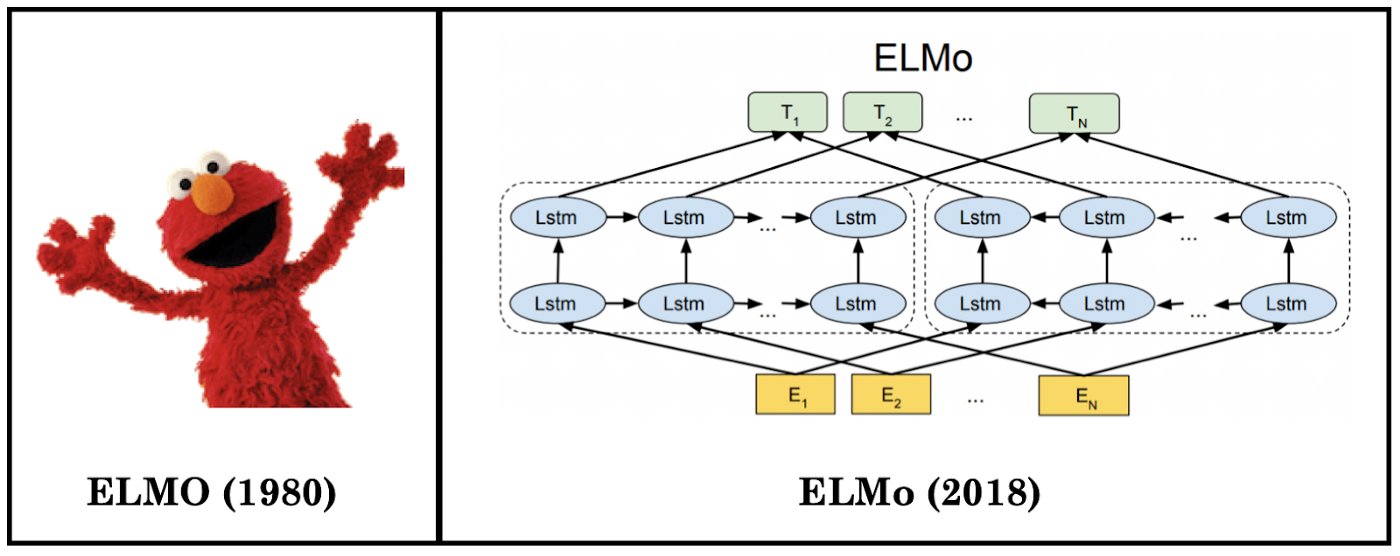

Для обучения векторов ELMo используется двунаправленная языковая модель (bidirectional Language Model или biLM). 

Модель вычисляет вероятность последовательности $t_1, t_2, \dots, t_N$.
Два прохода по тексту:
- прямой (forward): 
  - информация об определенном слове и контексте перед ним
  - вероятность $t_k$ при условии предшествующего контекста $t_1, ..., t_{k-1}$
- обратный (backward): 
  - информация о слове и контексте после него
  - вероятность $t_k$ при условии последующего контекста $t_{k+1}, \dots, t_N$

Важно: ELMo не имеет отношения к Трансформерам.

Модель состоит из двух слоев. На каждом слое обучается двунаправленная модель долгой краткосрочной памяти (biLSTM). 

Информация из прямого и обратного прохода на первом слое формирует промежуточные векторы слов, которые подаются на вход второго слоя модели. Результирующие векторы — взвешенная сумма необработанных векторов и двух промежуточных векторов.

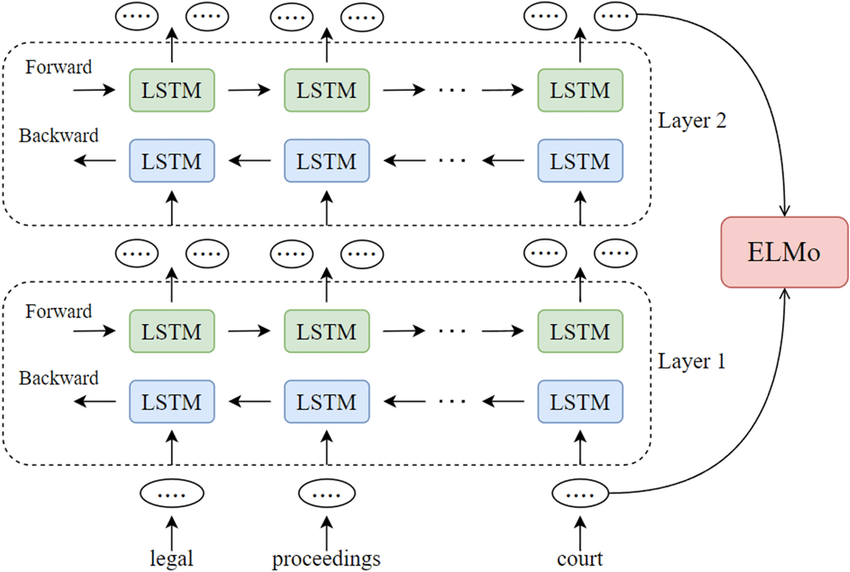

Поскольку модель обучается на задаче языкового моделирования, размеченные тексты не нужны, появляется возможность использовать большой объем данных для обучения. Модель выучивает некоторые общие знания о языке, не затачиваясь ни под какую конкретную задачу.

ELMo стала важным шагом к распространению переноса обучения в области NLP. Выходы модели ELMo могут использоваться как контекстуализированные эмбеддинги для различных задач обработки текста.

В случае word2vec каждому слову соответствует конкретный вектор, они могут быть сохранены в файл и затем взязы оттуда. 

ELMo строит контекстно зависимые вектора. Чтобы получить вектор для слов предложения, нужно сначала пропустить это предложение через модель. Обучения уже не происходит.

📌 Фиксированы ли векторы ELMo для слова и его значений?

Векторы для слова *bank*: значения 'берег' и 'финансовая организация'.

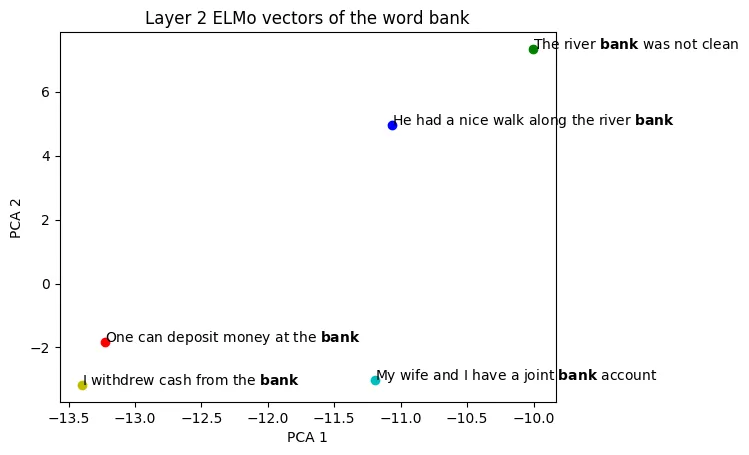

## Вторая модель на улице Сезам — BERT

Модель BERT была представлена в статье [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805).

Идеи, которые были предложены ранее и удачно объединились при создании модели BERT: 
- обучение на задаче языкового моделирования, которая не требует разметки, и перенос обучения (или предобучение) — ELMo
- механизм множественного внутреннего внимания, используемый без RNN, — Трансформер
- декодер Трансформера, который использует только левый контекст входного предложения, — GPT

Недостаток ELMo: анализируя левый и правый контекст отдельно с помощью biLSTM, мы можем терять часть информации. Хотелось бы учитывать левый и правый контекст одновременно.

Новшество BERT — использование **энкодера** Трансформера, чтобы получить "обогащенные" вниманием векторы слов.


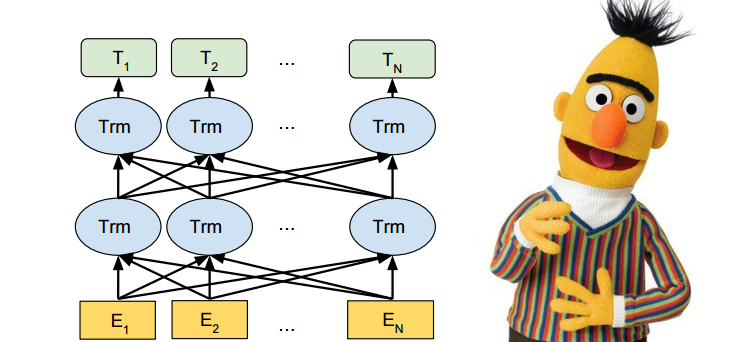

BERT состоит из нескольких последовательно соединенных блоков энкодера трансформера. 

На вход модель получает последовательность токенов, на выходе отдает векторное представление для каждого токена, обогащенное контекстом. Энкодер содержит механизм внутреннего внимания (Self-Attention), который применяется к каждому токену и позволяет улавливать контекст.

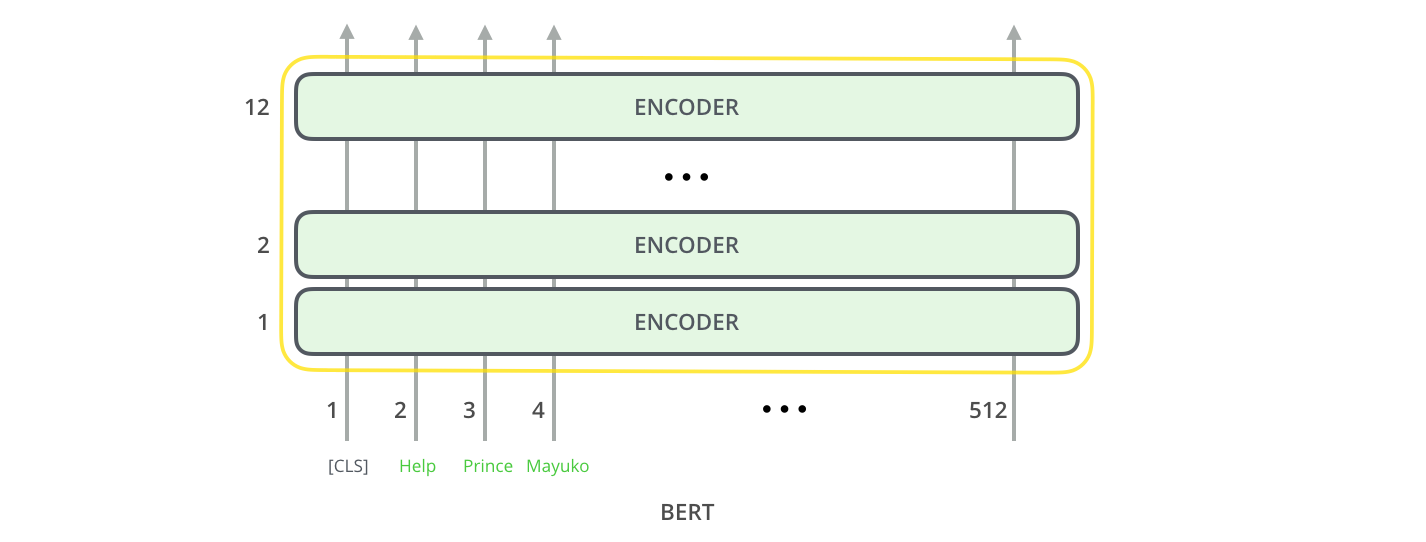

Две конфигурации: 
- базовая (base): 12 слоев, размер скрытого слоя — 768, 110 миллионов весов
- расширенная (large): 24 слоя, размер скрытого слоя — 1024, 340 миллионов весов

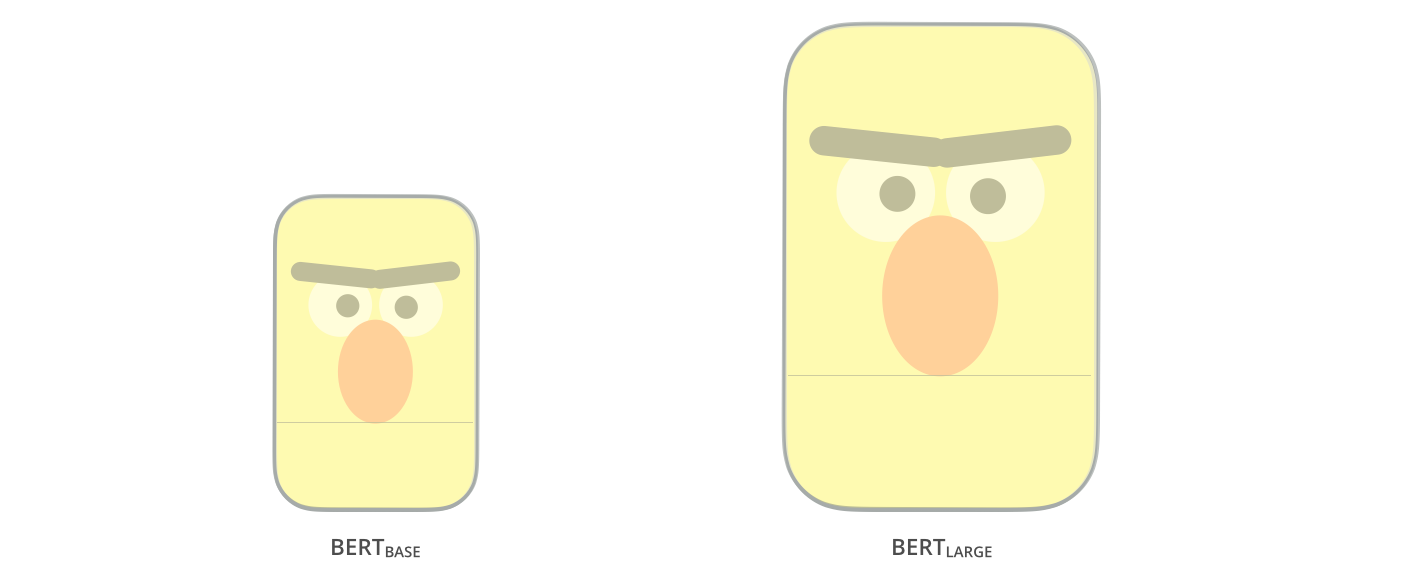

BERT обучается на двух задачах:
- маскированное языковое моделирование (masked language modeling, MLM)
- предсказание следующего предложения (next sentence prediction, NSP)

### Маскированное языковое моделирование

15% случайно выбранных токенов по всему корпусу маскируется — заменяется на спецтокен [MASK]. Задача модели — предсказать наиболее вероятный токен на месте маски.

📌 Как можно получить вероятности слов из векторов на выходе энкодера?

Если модель всегда должна будет предсказывать наиболее вероятное слово только для масок, то для остальных слов векторы будут обучаться хуже. Нужно "обмануть" модель, чтобы она смотрела на все слова входной последовательности.

Среди выбранных 15% токенов:
- 80% маскируются: my dog is [MASK]
- 10% меняются на случайное слово: my dog is apple
- 10% остаются: my dog is hairy

Это разбиение меняется на каждой эпохе обучения.

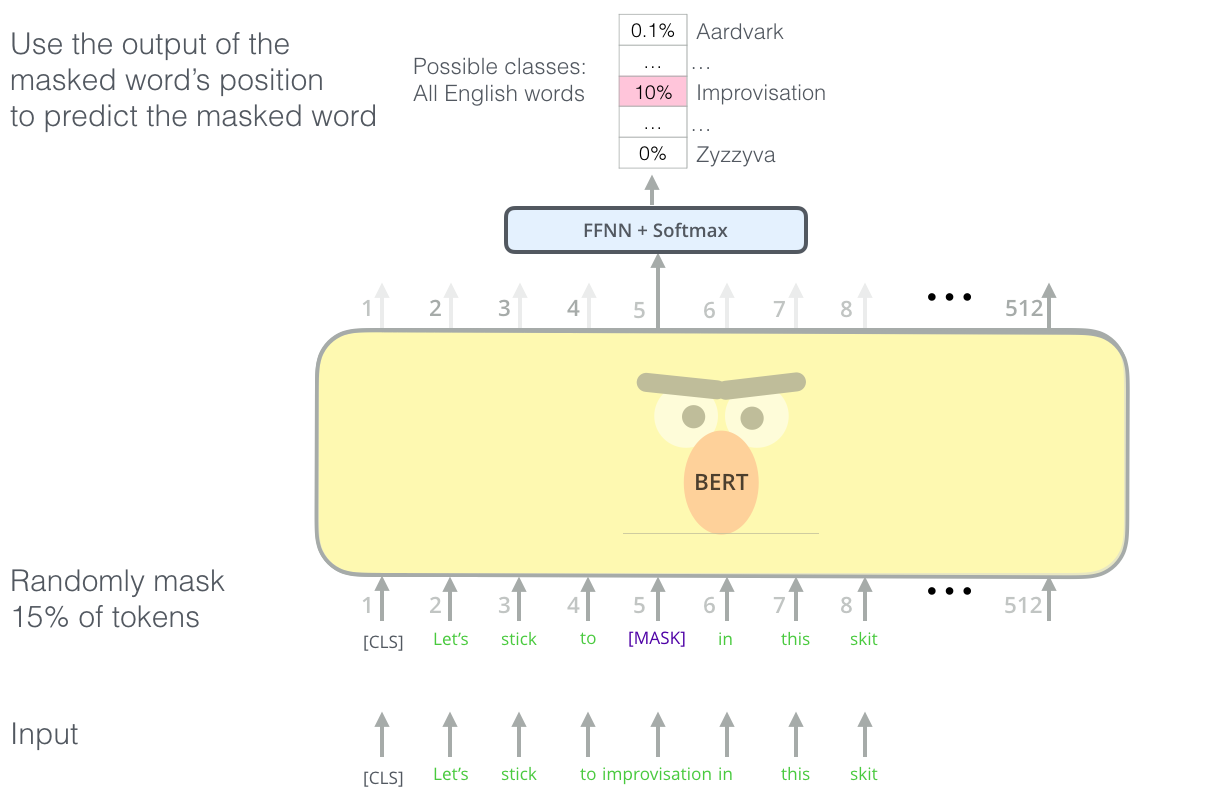

📌 На что похожа задача маскированного языкового моделирования — предсказания слова по контексту?

Обучение на задаче маскированного языкового моделирования позволяет получить контекстуализированные векторы токенов. Предобученные векторы можно использовать в других задачах обработки текста.

### Предсказание следующего предложения

Помимо векторов слов, хотелось бы получать также векторные представления предложений. Для этого попробуем предсказать, следует ли одно предложение за другим. 

Предложения разделены спецтокеном [SEP]. За классификацию отвечает спецтокен [CLS]. Он содержит представление обо всем предложении. Выход [CLS] токена пропускается через линейный слой размера 2. 

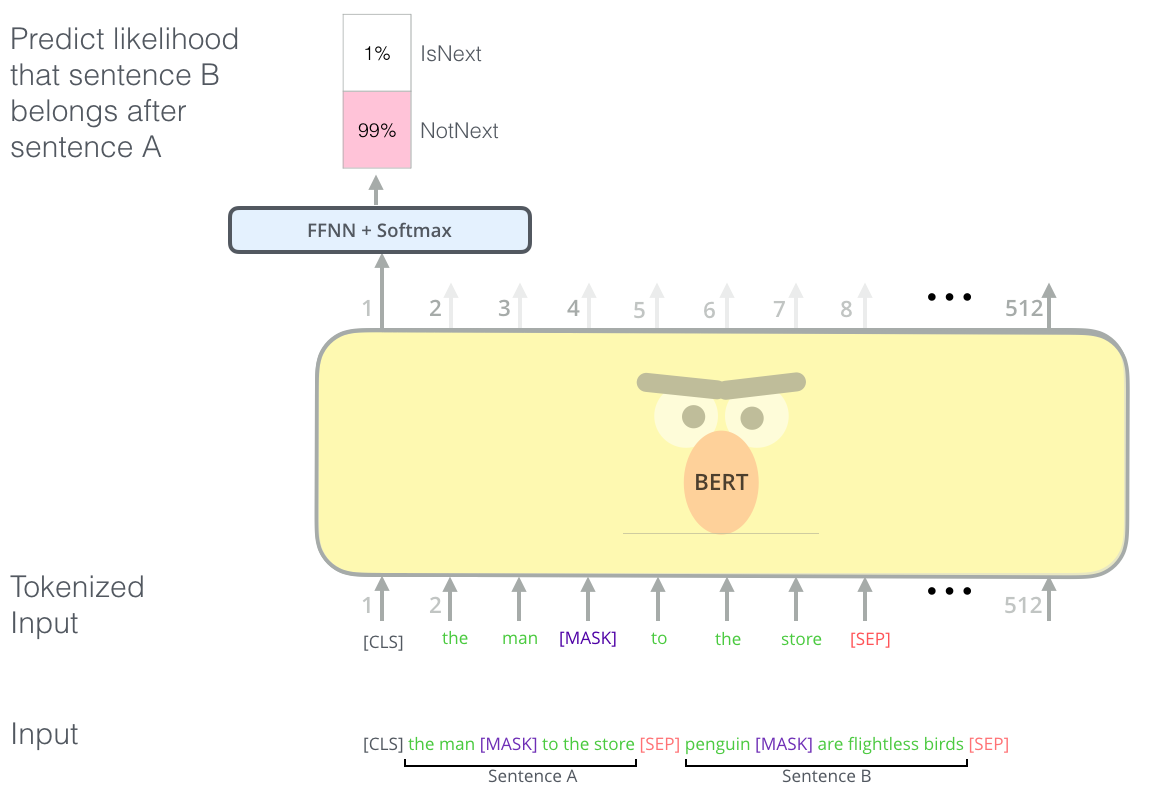

Положительные примеры представляют собой предложения, которые действительно следуют друг за другом в корпусе.

Вход: [CLS] the man went to the [MASK] store [SEP] he bought a gallon [MASK] milk [SEP] 

Метка: IsNext

Отрицательные примеры представляют собой предложения, которые выбираются случайно.

Вход: [CLS] the man [MASK] to the store [SEP] penguin [MASK] are flight ##less birds [SEP]

Метка: NotNext

📌 Насколько хорошим является такой способ подбора отрицательных примеров?

Обучение происходит по двум задачам параллельно. Значение функции потерь считается отдельно для маскированного языкового моделирования по токену [MASK] и для предсказания следующего слова по токену [CLS].

## Токенизация

📌 Какие единицы могут входить в словарь? Как при этом меняется размер словаря?

### BPE-токенизация

Byte Pair Encoding (BPE) — алгоритм для токенизации на подслова. Он позволяет эксплицитно задавать размер словаря.

Есть два полярных варианта: токенизация на слова и токенизация на символы. Будем последовательно двигаться от посимвольной токенизации к пословной. Остановимся в тот момент, когда будет достигнут нужный размер словаря.

Для каждого слова подсчитывается частота встречаемости в корпусе. Вначале все слова в корпусе разбиваются на символы, к последним символам прибавляется символ конца слова.

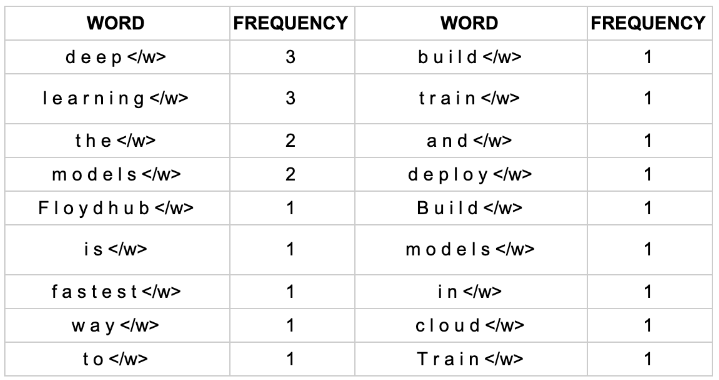

Теперь наш словарь состоит из символов. Для каждого подсчитана частота встречаемости в корпусе. Размер словаря равен 27.

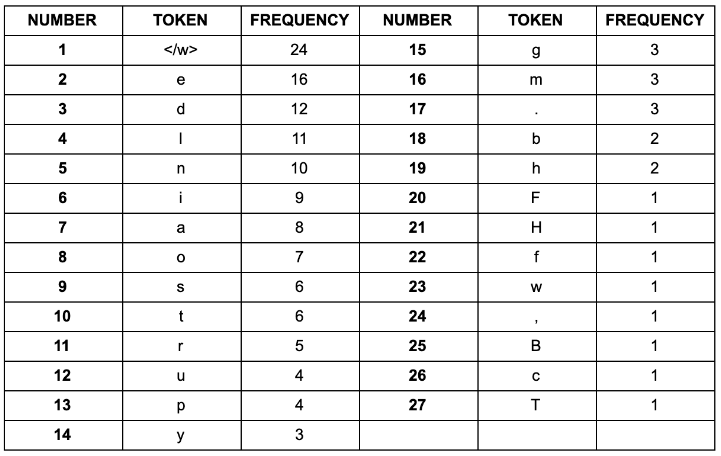

На каждом шаге мы хотим объединять символы, которые чаще всего встречаются вместе. 

Посчитаем частоту биграмм. В нашем корпусе самой частотной оказывается биграмма *de*.

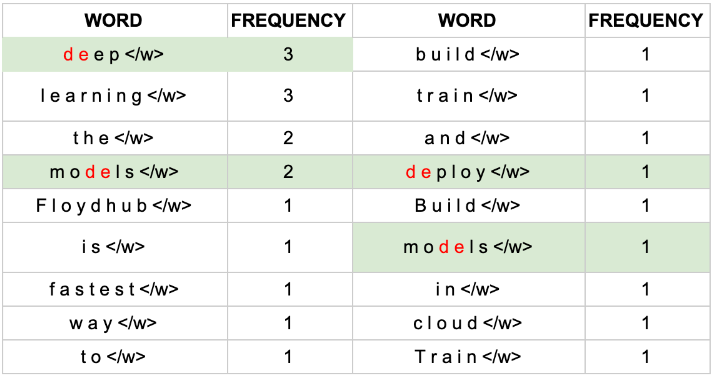

Теперь в словаре появилась одна биграмма. Размер словаря равен 28. При этом частота символов *d* и *e* понизилась, они стали более редкими.

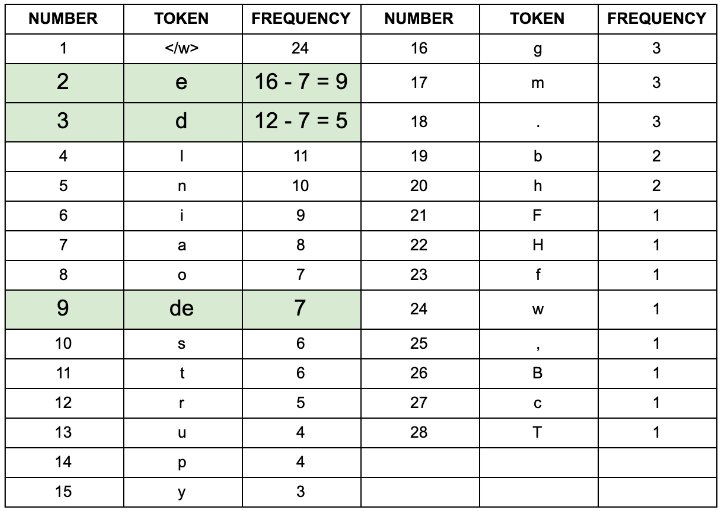

Аналогичное действие повторяется много раз. На каждом шаге в словарь добавляется новый токен (n-грамма).

📌 Может ли размер словаря уменьшиться на каком-то шаге?

В конце работы алгоритма словарь будет включать наиболее частотные слова, а более редкие будут представлены подсловами.

### WordPiece

В модели BERT используется похожий алгоритм WordPiece. Вместо подсчета частоты встречаемости используется другая метрика.

$score = \large \frac {freq\ of\ pair}{freq\ of\ first\ element\ \times freq\ of\ second\ element}$

Значение будет высоким, если элементы по отдельности встречаются редко, и низким, если они часто встречаются по отдельности.

На каждом шаге объединяются n-граммы, для которых значение метрики максимально.

## Библиотека Transformers

Библиотека [Transformers](https://huggingface.co/docs/transformers/index) создана сообществом HuggingFace. Она позволяет работать с открытыми трансформерными моделями.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


В библиотеке реализованы классы для различных архитектур — в том числе, для модели [BERT](https://huggingface.co/docs/transformers/model_doc/bert).

Нам понадобятся классы [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer) и [BertForMaskedLM](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForMaskedLM). Для загрузки конкретных моделей используется метод `.from_pretrained`.

BERT — это общее название архитектуры. С её использованием были обучены модели на различных языках и датасетах. Все модели, которые доступны на HuggingFace, можно посмотреть в разделе [Models](https://huggingface.co/models). Чтобы загрузить модель, нужно указать её идентификатор.

### BertTokenizer

Загрузим токенизатор для модели [BERT base cased](https://huggingface.co/bert-base-cased) для английского языка.

In [ ]:
from transformers import BertTokenizer 
en_tz = BertTokenizer.from_pretrained("bert-base-cased")

Токенизируем английское предложение с помощью метода `.tokenize()`. 

In [ ]:
sent = "He remains characteristically confident and optimistic."
tokenized_sent = en_tz.tokenize(sent)
tokenized_sent

['He',
 'remains',
 'characteristic',
 '##ally',
 'confident',
 'and',
 'optimistic',
 '.']

Если какое-то слово не представлено в словаре целиком, при токенизации оно делится на подслова.

Посмотрим, какие индексы в словаре соответствуют словам, с помощью метода `convert_tokens_to_ids()`.

In [ ]:
en_tz.convert_tokens_to_ids(tokenized_sent)

[1124, 2606, 7987, 2716, 9588, 1105, 24876, 119]

📌 Загрузите токенизатор для модели на основе архитектуры BERT для другого языка (не английского) и попробуйте подобрать предложение, где при токенизации одно или более слов делятся на подслова.

In [ ]:
# Место для вашего кода

In [ ]:
ru_tz = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [ ]:
ru_tz.tokenize("Сельскохозяйственно-машиностроительный"), ru_tz.tokenize("Частнопредпринимательский")

(['Сельскохозяй', '##ственно', '-', 'машиностроительный'],
 ['Част', '##ноп', '##ред', '##приним', '##атель', '##ский'])

In [ ]:
de_tz = BertTokenizer.from_pretrained("bert-base-german-cased")

In [ ]:
de_tz.tokenize("die Aufmerksamkeitsdefizitstörung"), de_tz.tokenize("das Ampelmännchen")

(['die', 'Aufmerksamkeit', '##s', '##de', '##fizit', '##störung'],
 ['das', 'Amp', '##el', '##männ', '##chen'])

### BertForMaskedLM

Загрузим саму модель [BERT base cased](https://huggingface.co/bert-base-cased) для английского языка.

In [ ]:
from transformers import BertForMaskedLM
en_model = BertForMaskedLM.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Поскольку модель обучалась на задаче маскированного языкового моделирования, она способна предсказывать наиболее вероятные слова на месте спецтокена [MASK]. 

Напишем функцию `predict_mask`, которая находит распределение вероятностей для маски.
- Добавим спецтокены [CLS] и [SEP]

 📌 Токенизируем текст (`text`)
- Определим индекс маскированного слова

 📌 Переведем токенизированные слова (`tokenized_text`) в индексы
- Запишем индексы в тензор
- Применим модель к токенизированному предложению
- Запишем выходы модели для каждого слова

 📌 Применим софтмакс (`torch.softmax()`) к результатам для маскированного слова, его найдем среди всех выходов модели (`predictions`) по индексу (`masked_index`)
- Запишем k самых больших значений весов и их индексы, которые соответствуют словам в словаре 
- Пройдем в цикле по списку индексов
  - Переведем каждый индекс в соответствующий токен
  - Запишем его вероятность

In [ ]:
import torch

def predict_mask(tokenizer, model, text, top_k=5):
    
    text = f"[CLS] {text} [SEP]"
    tokenized_text = tokenizer.tokenize(text) # Место для вашего кода
    masked_index = tokenized_text.index("[MASK]")
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # Место для вашего кода
    tokens_tensor = torch.tensor([indexed_tokens])

    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs["logits"].squeeze()
    
    probs = torch.softmax(predictions[masked_index,:], dim=-1) # Место для вашего кода
    top_k_weights, top_k_indices = torch.topk(probs, top_k)

    for i, pred_idx in enumerate(top_k_indices):
        predicted_token = tokenizer.convert_ids_to_tokens([pred_idx])[0]
        token_weight = top_k_weights[i]
        print("[MASK]: '%s'"%predicted_token, " | weights:", float(token_weight))

In [ ]:
predict_mask(en_tz, en_model, "My [MASK] is so cute.", top_k=5)

[MASK]: 'mom'  | weights: 0.11396888643503189
[MASK]: 'brother'  | weights: 0.08857091516256332
[MASK]: 'sister'  | weights: 0.07716383039951324
[MASK]: 'dad'  | weights: 0.04623359441757202
[MASK]: 'girl'  | weights: 0.0430966280400753


📌 Загрузите модель на основе архитектуры BERT для другого языка (не английского) и примените функцию к предложению, где одно слово маскировано.

In [ ]:
# Место для вашего кода

In [ ]:
ru_model = BertForMaskedLM.from_pretrained("DeepPavlov/rubert-base-cased")

In [ ]:
predict_mask(ru_tz, ru_model, "Моя [MASK] очень милая.", top_k=5)

[MASK]: 'семья'  | weights: 0.16033968329429626
[MASK]: 'дочь'  | weights: 0.11803407967090607
[MASK]: 'жизнь'  | weights: 0.051933880895376205
[MASK]: 'девушка'  | weights: 0.05192675441503525
[MASK]: 'мама'  | weights: 0.043039675801992416


In [ ]:
de_model = BertForMaskedLM.from_pretrained("bert-base-german-cased")

In [ ]:
predict_mask(de_tz, de_model, "Meine [MASK] ist sehr nett.", top_k=5)

[MASK]: 'Frau'  | weights: 0.4413629174232483
[MASK]: 'Freundin'  | weights: 0.13459962606430054
[MASK]: 'Tochter'  | weights: 0.12829922139644623
[MASK]: 'Mutter'  | weights: 0.09246476739645004
[MASK]: 'Schwester'  | weights: 0.03401939198374748
